# Meow Demo

> optimizing a waveguide bend

In [ ]:
#| default_exp meowdemo


The question states:
> What’s the minimum bend radius for an euler bend for 400nm thick silicon for 1um wide waveguides at 1550nm for TE polarization. What’s the optimal radius and p parameter?

Let's first get an intuition for the modes supported by a 400nmx1um silicon waveguide

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
from skill_challenge.util import np, gf, gt, plt, nm, cachedComputeModes

In [ ]:
from functools import lru_cache

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import meow as mw

import numpy as np
from scipy.special import fresnel
from tqdm.notebook import tqdm
from typing import Optional

eps = np.finfo(np.float64).resolution

In [ ]:
def create_material(
    name: str,
    n: complex,
    wl: float,
    color: str = "grey"
):
  c = list(colors.to_rgba(color))
  c[-1] = 0.5
  print(c)

  return mw.Material(
      name=name, params={"wl":np.array([wl])}, n=np.array([n]), meta={"color": tuple(c)})

In [ ]:
#@title Settings
T = 38.0        #@param {type:"number"}  #Temperature in deg C
wl_start = 0.8  #@param {type:"number"}  #Start wavelength in um
wl_stop = 0.9   #@param {type:"number"}  #Stop wavelength in um
#num_wl = 5      #@param {type:"number"}  #number of wavelengths
w = 0.7         #@param {type:"number"}  #waveguide width in um
t_slab = 0      #@param {type:"number"}  #slab thickness in um
t_core = 0.160  #@param {type:"number"}  #core thickness in um
t_ox = 3        #@param {type:"number"}  #cladding thickness in um; full extend
num_modes = 12   #@param {type:"number"}  #number of considered modes
num_cells = 35 + 3 #@param {type:"number"}  #number of cells in eme
n_wg = 3.45     #@param {type:"number"}  #refractive index of the core
n_ox = 1.46     #@param {type:"number"}  #refrective index of the cladding
alpha_tot = np.pi/2 #angle of the full turn
R_eff =  40     #@param {type:"number"}  #effective Radius in um

R_eff_min = 40  #@param {type:"number"}  #minimum effective Radius in sweep
R_eff_max = 50 #@param {type:"number"}  #maximum effective Radius in sweep
R_eff_points = 2
R_eff_sweep = np.logspace(
    np.log10(R_eff_min), 
    np.log10(R_eff_max), 
    R_eff_points)

p = 0.5         #@param {type:"number"}  #part of the bend that is euler
p_sweep = np.linspace(0.01, 0.99, 11)

wl_mean = np.mean([wl_start, wl_stop])
mat_core = create_material("sin", 2.02, wl_mean, "green")
mat_clad = create_material("sio", 1.46, wl_mean, "grey")

[0.0, 0.5019607843137255, 0.0, 0.5]
[0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.5]


## Euler Bend Intro

As we want to use `scipy.special.fresnel` to evaluate the fresnel integrals, we have to express the cos/sin argument as $\frac{\pi t^2}{2}$ while it is $\frac{t^2}{2R_0^2}$ in the euler spiral. Thus let's chose $R_0 = 1/\sqrt{\pi}$

In [ ]:
def R_0() -> float:
  """reference radius for use in fresnel integral"""
  return 1/np.sqrt(np.pi)

From the paper we know that we have to trace the path up to $s(\alpha) = R_0\sqrt{2\alpha}$ (eq. 3)
thus to the end of the first euler section we find.
Note: The angle at the end of the first euler part is $p\alpha_{tot}/2$

In [ ]:
def s_p(R_0:float, alpha_tot: float, p: float):
  """path length at interface between euler and circular bend"""
  return R_0*np.sqrt(p*alpha_tot)

The radius of the circular section (unscaled) $R_p = \frac{R_0}{2\sqrt{p\alpha/2}}$
Note: this formula was found to not lead to the correct results. The corrected formula was taken from the `gdsfactory` euler bend implementation:
$$R_p = \frac{R_0}{\sqrt{p\alpha}}$$

In [ ]:
def R_p(R_0:float, alpha_tot: float, p: float):
  """radius of the circular bend"""
  return R_0/np.sqrt(p*alpha_tot)

The total bend lengths results as:

In [ ]:
def s_0(s_p:float, R_p:float, alpha_tot: float, p: float):
  """total path length of the partial euler bend"""
  return 2*s_p + R_p*alpha_tot*(1-p)

In [ ]:
def eval_params(alpha_tot: float, p: float):
  _R_0 = R_0()
  _s_p = s_p(_R_0, alpha_tot, p)
  _R_p = R_p(_R_0, alpha_tot, p)
  _s_0 = s_0(_s_p, _R_p, alpha_tot, p)
  return _R_0, _s_p, _R_p, _s_0

def partial_euler_unscaled(alpha_tot: float, p: float):
  
  R_0, s_p, R_p, s_0 = eval_params(alpha_tot, p)

  y_p, x_p = fresnel(s_p)
  pa_2 = p*alpha_tot/2
  delta_x = x_p - R_p*np.sin(pa_2)
  delta_y = y_p - R_p*(1-np.cos(pa_2))

  def arg(s):
    """Used to simplify the expressions a bit"""
    return (s-s_p)/R_p + pa_2


  def x_bend(s):
    if s<0 or s>s_0/2:
      raise ValueError()

    if s>s_p:
      return R_p*np.sin(arg(s)) + delta_x
    else:
      y, x = fresnel(s)
      return x

  def y_bend(s):
    if s<0 or s>s_0/2:
      raise ValueError()

    if s>s_p:
      return R_p*(1-np.cos(arg(s))) + delta_y
    else:
      y, x = fresnel(s)
      return y
  
  return x_bend, y_bend, s_0

In the following we will be calculating the rescaling factor. We need to evaluate $x_{bend}(s_0/2)$ and $y_{bend}(s_0/2)$ for that purpose.

In [ ]:
def euler_bend_scaled(alpha_tot: float, p: float, R_eff: float):
  x_bend, y_bend, s_0 = partial_euler_unscaled(alpha_tot , p)
  x_0 = x_bend(s_0/2)
  y_0 = y_bend(s_0/2)
  eta = R_eff / (y_0+x_0/np.tan(alpha_tot/2))

  def xy_scaled_bend(s):
    x = np.array([x_bend(s_i) for s_i in s])
    y = np.array([y_bend(s_i) for s_i in s])
    return x*eta, y*eta
  
  return xy_scaled_bend, eta

## Comparison `gdsfactory`
let`s compare our results to gdsfactory

In [ ]:
def partial_euler_bend(alpha_tot:float, p:float, R_eff:float, num_points:float=200, radii:Optional[np.ndarray]=None):
  """
    evaluates the euler part of a partial euler bend + one point at the beginning and end of the circular part. 
    returns the x,y coordinates, radii and angles of points on the curve
  """
  R_0, s_p, R_p, s_0 = eval_params(alpha_tot, p)

  xy_scaled_bend, eta = euler_bend_scaled(alpha_tot, p, R_eff)

  if radii is None:
    s = np.linspace(0, s_p, num_points) # euler part
    radii = eta * R_0**2/(s+eps) 
  else:
    s = eta * R_0**2/radii
    radii = radii[s<s_p]
    s = s[s<s_p] #don't go overboard

  angles = (s/R_0)**2/2

  # Add in center point

  radii = np.append(radii, [R_p*eta]*2)
  s = np.append(s, [s_p, s_0/2])
  angles = np.append(angles, [alpha_tot/2*p, alpha_tot/2])
  length = s*eta

  return *xy_scaled_bend(s), radii, angles, length

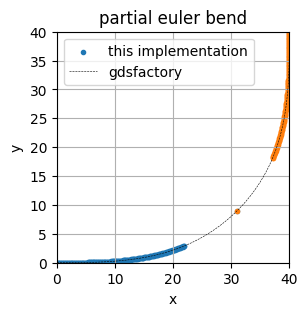

In [ ]:
plt.figure(figsize=(3, 3))
plt.title("partial euler bend")
plt.xlim(0,R_eff)
plt.ylim(0,R_eff)

x, y, radii, angles, l = partial_euler_bend(alpha_tot, p, R_eff)
plt.scatter(x, y, marker = ".", label="this implementation")
plt.scatter(R_eff-y, R_eff-x, marker = ".")

import gdsfactory as gf
pa = gf.path.euler(radius=R_eff, angle=90, p=0.5, use_eff=True, npoints=720)
plt.plot(pa.points[:,0], pa.points[:,1], "k--", linewidth=0.4, label="gdsfactory")

plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left")


# EME assembly

## Straight Geometry

In [ ]:
@lru_cache(maxsize=None)
def create_geometry(L=2.0, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab):
    core_ox = mw.Structure(
        material=mw.silicon_oxide,
        geometry=mw.Box(
            x_min=-w / 2 - t_ox / 2,
            x_max=w / 2 + t_ox / 2,
            y_min=0.0,
            y_max=t_core + t_ox,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    slab_ox = mw.Structure(
        material=mw.silicon_oxide,
        geometry=mw.Box(
            x_min=-4,
            x_max=4,
            y_min=-2.0,
            y_max=t_slab + t_ox,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    core = mw.Structure(
        material=mw.silicon,
        geometry=mw.Box(
            x_min=-w / 2,
            x_max=w / 2,
            y_min=0.0,
            y_max=t_core,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    slab = mw.Structure(
        material=mw.silicon,
        geometry=mw.Box(
            x_min=-4,
            x_max=4,
            y_min=0.0,
            y_max=t_slab,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    return [core_ox, slab_ox, core, slab]

In [ ]:
mw.visualize(create_geometry(), scale=(1.0, 1.0, 5.0))

trimesh: threejs viewer

## Cell

In [ ]:
def create_cell(bend_radius, L, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab):
    structs = create_geometry(L=L, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab)
    cell = mw.Cell(
        structures=structs,
        mesh=mw.Mesh2d(  # decrease approx_dy for more accuracy
            x=_mesh_x(-2.5, 2.5, w, approx_dx=0.05),
            y=_mesh_y(-1.5, 1.5, t_core, approx_dy=0.05),
            bend_radius=bend_radius,
            num_pml=(10, 10),
        ),
        z_min=-L / 2,
        z_max=L / 2,
    )
    return cell


@lru_cache(maxsize=None)
def _mesh_y(start, stop, height_core, approx_dy=0.02):
    """special meshing that makes the pixel boundaries coincide with structure boundaries for better accuracy"""
    num_cells = int(abs(stop - start) / approx_dy + 0.5)
    num_core_cells = int(height_core / approx_dy + 0.5)
    dy = height_core / num_core_cells
    y = np.arange(start, stop, dy)
    idx = np.argmin(abs(y))
    y -= y[idx]
    y = _make_length(y, num_cells)
    # print(y.shape, y[:2] - y[0])
    return y


@lru_cache(maxsize=None)
def _mesh_x(start, stop, width_core, approx_dx=0.02):
    """special meshing that makes the pixel boundaries coincide with structure boundaries for better accuracy"""
    num_cells = int(abs(stop - start) / approx_dx + 0.5)
    num_core_cells = int(width_core / approx_dx + 0.5)
    dx = width_core / num_core_cells
    x = np.arange(start, stop, dx)
    idx = np.argmin(abs(x - width_core / 2))
    x -= x[idx]
    x += width_core / 2
    x = _make_length(x, num_cells)
    # print(x.shape, x[:2] - x[0])
    return x


def _make_length(x, L):
    if x.shape[0] > L:
        return x[:L]
    elif x.shape[0] == L:
        return x
    else:
        dx = x[-1] - x[-2]
        N = L - x.shape[0]
        extra = np.array([x[-1] + (n + 1) * dx for n in range(N)])
        x = np.concatenate([x, extra], 0)
        return x

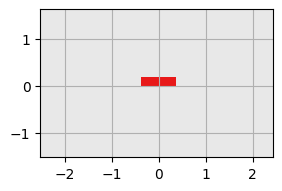

In [ ]:
mw.visualize(create_cell(bend_radius=50.0, L=10))

## Cross Section

We can create a cross section from a cell as follows:

In [ ]:
def create_cross_section(
    bend_radius, L, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab, wl=wl_mean, T=T
):
    env = mw.Environment(
        wl=wl,
        T=T,
    )
    cs = mw.CrossSection(
        cell=create_cell(bend_radius, L=L, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab),
        env=env,
    )
    return cs

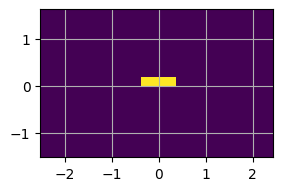

In [ ]:
mw.visualize(create_cross_section(bend_radius=50.0, L=10))

> Note: bend radius is not visualized on cross section visualizations

## Multiple Cross Sections

In [ ]:
def sample_euler_radii(
    num_cells: int, R_eff_min: float, R_eff: float, alpha_tot:float, p:float
):
  """
    sample the euler bend on a equidistant curvature grid.
     Args:
        num_cells: number of samples taken from the curve
        R_eff_min: minimum R_eff for subsequent sweep, to reuse radii/modes
        R_eff: effective Radius for this run
        alpha_tot: angle of the complete partial euler bend
        p: part of bend that is euler (in contrast to circular)
  """

  curvatures = np.linspace(eps,1/R_eff_min, num_cells-3)

  dcurvatures = np.diff(curvatures) #halfinteger grid
  curvatures_ = curvatures[:-1] + dcurvatures/2

  def prepareSlices(curvs):
    radii = 1/curvs
    return partial_euler_bend(alpha_tot, p, R_eff, radii=radii)

  x,y,r,a,l      = prepareSlices(curvatures)
  x_,y_,r_,a_,l_ = prepareSlices(curvatures_)

  return l, r, l_, r_

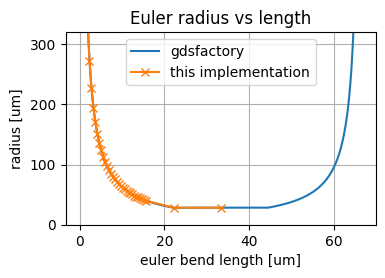

In [ ]:
l, r, l_, r_ = sample_euler_radii(num_cells, R_eff_min, R_eff, alpha_tot, p)
s_gf, curv_gf = pa.curvature()
radii_gf = 1/curv_gf

plt.figure(figsize=(4, 2.5))
plt.title("Euler radius vs length")
plt.plot(s_gf, radii_gf, label="gdsfactory")
plt.plot(l,r, marker="x", label="this implementation")
#plt.xlim(0, R_eff/2)
plt.ylim(0, R_eff*8)
plt.grid(True)
plt.xlabel("euler bend length [um]")
plt.ylabel("radius [um]")
plt.legend()

In [ ]:
def sample_cross_sections(
    num_cells: int, R_eff_min: float, R_eff: float, alpha_tot:float, p:float
):
  l, r, l_, r_ = sample_euler_radii(num_cells, R_eff_min, R_eff, alpha_tot, p)
  Rs = np.concatenate([[1e100], r_, [r[-1]]])  # always good to have a zero-length cell at start and end.
  Ls = np.concatenate([[0], np.diff(l), [0]])  # always good to have a zero-length cell at start and end.
  return [create_cross_section(R, L, wl=wl_mean) for R, L in zip(Rs, Ls)]

## Calculate Modes

In [ ]:
from skill_challenge.util import cMode

In [ ]:
def calculate_modes(
    num_cells: int, R_eff_min: float, R_eff: float, alpha_tot:float, p:float
):
  css = sample_cross_sections(num_cells, R_eff_min, R_eff, alpha_tot, p)
  return [cachedComputeModes(cs, num_modes) for cs in tqdm(css, leave=False)]

In [ ]:
#|eval: false
modes = calculate_modes(num_cells, R_eff_min, R_eff, alpha_tot, p)
for m in modes[0]:
  print(hash(cMode(mode = m)))

  0%|          | 0/38 [00:00<?, ?it/s]

-3555524543836233444
1291600307780887307
4716460518991691455
6463269614036853193
8831064949055429951
5301669868322556901
-4276652992439090351
7948826313154836025
-6866412678402481768
-8471146516271151219
-3510724254523753332
-1717320677343134389


Calculating the modes again should be at almost no cost, as they are cached

In [ ]:
#|eval: false
modes = calculate_modes(num_cells, R_eff_min, R_eff, alpha_tot, p)
for m in modes[0]:
  print(hash(cMode(mode = m)))

  0%|          | 0/38 [00:00<?, ?it/s]

-3555524543836233444
1291600307780887307
4716460518991691455
6463269614036853193
8831064949055429951
5301669868322556901
-4276652992439090351
7948826313154836025
-6866412678402481768
-8471146516271151219
-3510724254523753332
-1717320677343134389


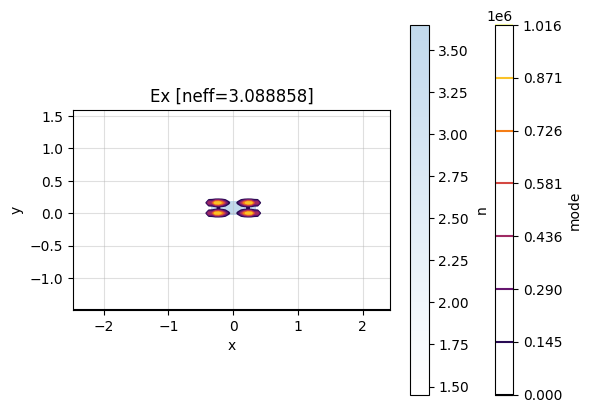

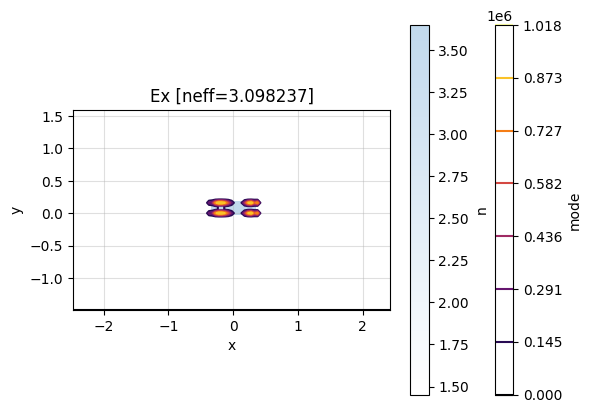

In [ ]:
#|eval: false
mw.visualize(modes[0][2])
mw.visualize(modes[-1][2])

## Calculate S-matrix

In [ ]:
from meow.eme import compute_interface_s_matrix as originalInterface
from typing import Tuple, List
from meow import Mode

@lru_cache(maxsize=None)
def innerInterface( modes1: Tuple[cMode], 
                    modes2: Tuple[cMode], 
                    *args, **kwargs):
  #print("recalculating")
  result = originalInterface(
      [m.getMode() for m in modes1],
      [m.getMode() for m in modes2],
      *args, **kwargs
  )
  return result


def cachedComputeInterfaces(modes: List[List[Mode]], *args, **kwargs):
  """get all the S-matrices of all the interfaces in a collection of `CrossSections`"""
  return {
      f"i_{i}_{i + 1}": cachedSingle(
          modes1=modes1,
          modes2=modes2,
          *args, **kwargs
      )
      for i, (modes1, modes2) in enumerate(zip(modes[:-1], modes[1:]))
  }

def cachedSingle(modes1: List[cMode], 
                 modes2: List[cMode], *args, **kwargs):
  #print("searching cache")
  return innerInterface(
      tuple([cMode(mode=m) for m in modes1]),  
      tuple([cMode(mode=m) for m in modes2]), 
      *args, **kwargs
    )


In [ ]:
#|eval: false
import xarray as xr
from tqdm.notebook import tqdm
results_tot = []
for i, _R_eff in enumerate(tqdm(R_eff_sweep)):
  results_reff = []
  for _p in tqdm(p_sweep, leave=False):
    modes = calculate_modes(num_cells, R_eff_min, _R_eff, alpha_tot, _p)
    S, port_map = mw.compute_s_matrix(modes) #sax_backend="klu", compute_interface_s_matrices = cachedComputeInterfaces
    results_reff.append(np.abs(S))
  results_tot.append(results_reff)

  results = xr.DataArray(results_tot, dims=("R_eff", "p", "port_in", "port_out"), coords={"R_eff": R_eff_sweep[:i+1], "p": p_sweep})
  results.to_netcdf('euler_sweep_tmp.nc')


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Post Processing

In [ ]:
import xarray, numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
viridis = plt.get_cmap('viridis')
plt.rcParams['figure.figsize'] = (3,2)

In [ ]:
def load_data(suffix):
  return xarray.open_dataarray(f'../assets/euler_sweep{suffix}.nc')

In [ ]:
from scipy.optimize import curve_fit

def power_law(x, k, m):
  return k*np.power(x, m)

def i_power_law(y, k, m):
  return np.power(y/k, 1/m)

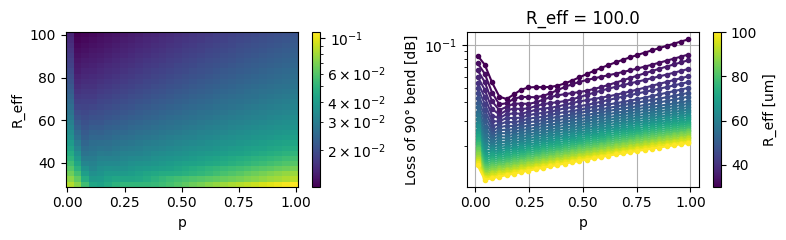

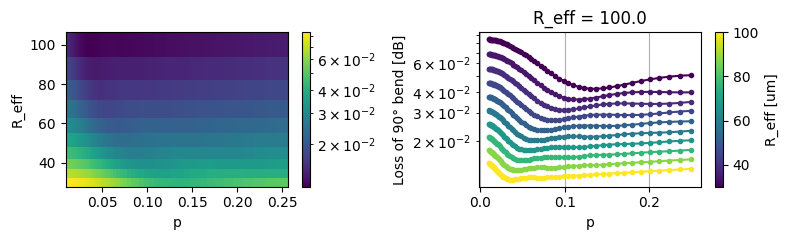

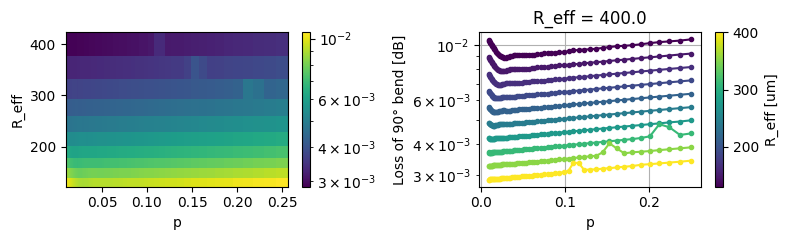

In [ ]:
#@title Optimal p { vertical-output: true}
for suffix in ["tmp"]:
  try:
    data = load_data(suffix)
    plt.figure(figsize=(8,2.5))
    plt.subplot(121)
    Z = - 2* 20*np.log10(data[:, :, 0,7])
    Z.plot(norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))

    plt.subplot(122)
    vmin = Z["R_eff"].min()
    vmax = Z["R_eff"].max()
    for z in Z:
      z.plot(color = viridis((z["R_eff"]-vmin)/(vmax-vmin)), marker=".")
    plt.colorbar(
        cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=viridis),
        label = "R_eff [um]",
        ax = plt.gca()
    )
    plt.yscale("log")
    plt.ylabel("Loss of 90° bend [dB]")
    plt.grid()
    plt.tight_layout()
    
  except:
    pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

: 